# Do Batters Affect How Pitchers Throw?
## Baseline independance testing between the type of pitch thrown and pitch number during a plate appearance
### Based on MLB statcast data from the first half of 2024

##### This report is compromised of 2 main parts
1. Proving that a pitchers pitch type is not dependent on how many times he has thrown the ball during the plate appearance.
    - I.E. is a pitcher just as likely to throw a fast ball in his 4th ball with this batter as he is with his first

<br>

2. Finding a subset of all batters with an average of at least 3.1 plate appearances per game
   - When finding which batters to collect batting data from, we will only want to select batters who are on the plate enough to not be considered a rare batter. The MLB requires an average of 3.1 plate appearances for a player to be elible for certain batting awards, so we have chosen this as our requirement

_________________________________________________

### Imports and data reading

In [39]:
import pandas as pd
import seaborn as sns
import scipy.stats as scipy
import matplotlib.pyplot as plt
import numpy as np
import statistics as stat
import math

In [40]:
bdf = pd.read_csv('statcast_pitch_swing_data_20240402_20240630.csv')
sns.set_theme(style='darkgrid')

____________________________________________________________________

## 1. Preparation: Reclassify small amounts to be able to conduct hypothesis testing
Before starting to conduct any tests between pitch types and the pitch numbers, the rarely used pitch types and numbers need to be addressed. As will be shown below, some pitch types and pitch numbers rarely show up in the data. This will cause skew in testing down the line if they are not addressed.

### 1.1 Data Selection
In selecting the data, I drop around 250 rows with no information for pitch type. This data is miniscule and would not prove useful when analyzing pitch type usage.

In [43]:
bdf_pitch = bdf[['pitch_number', 'pitch_name']].dropna(axis='index')   #Select relevant info, drop empty rows
pitch_names = list(bdf_pitch['pitch_name'].unique())     #gather all unique pitch names to parse through later
pitch_nums = [i for i in range(1,15)]                     #create list of all pitcher numbers as it gets interated through multiple times

### 1.2 Group together all rarely used pitches and pitch numbers together

Grouping together all of the rarely recorded pitch numbers and pitch types would allow them to tested as a group with adequate sample size. Then if there were conclusions needing to be made about that group, some tests could be run on them individually. This process allows for accurate hypothesis testing without skew from small sample sizes.

For grouping the pitch types, I decided to group all pitch types that are used less than 1% of the time. This means a pitch is rare and likely has something fundamentally different from the other pitch types. It also removes most of the small sample size issues associated with these pitches. 

The code below shows that these pitches make up only 0.67% of all pitches, which makes me confident that this data grouping will not have extreme effects on the dataset as a whole.

In [45]:
pitchprob_df = pd.DataFrame(index=pitch_names, columns=['probability'])

for name in pitch_names: #For each pitch type, find its percent usage using the count of the pitch divided by total pitches
    pitchprob_df.loc[name, 'probability'] = round(len(bdf_pitch[bdf_pitch['pitch_name']==name])/len(bdf_pitch),4)

pitchprob_df = pitchprob_df.sort_values(by='probability',ascending=False) #sort, having lowest values at the bottom
print(f'The sum of the probabilities of all pitches with less than 0.01 usage is {pitchprob_df[pitchprob_df['probability']<0.01].sum().iloc[0]} ')    

The sum of the probabilities of all pitches with less than 0.01 usage is 0.0067 


The pitch numbers experience a sharp decrease in percent appearance as they increase with no very obvious boundary. I have grouped together all pitches with a pitch number greater than 10. This is somewhat arbitrary, but in practice it appears be the smallest grouping that also removes nearly all of the sample size issues.

The code below shows that these pitches with a pitch number greater than 10 make up only 0.07% of all the data. This makes me confident this grouping should have no major effects on the dataset as a whole.

In [47]:
pitchnum_prob = pd.DataFrame(index=pitch_nums, columns=['probability'])  #create dataframe for pitch number probabilities

for num in pitch_nums:  #find % usage of each pitch number
    pitchnum_prob.loc[num, 'probability'] = round(len(bdf_pitch[bdf_pitch['pitch_number']==num])/len(bdf_pitch),4)

pitchnum_prob = pitchnum_prob.sort_values(by='probability') #descending sort
print(f'Pitches with a pitch number over 10 take up {pitchnum_prob.loc[[i for i in range(11,15)]].sum().iloc[0]}% of the data')

Pitches with a pitch number over 10 take up 0.0007000000000000001% of the data


The charts below will show the fall off  with the usage of both pitch type and pitch number

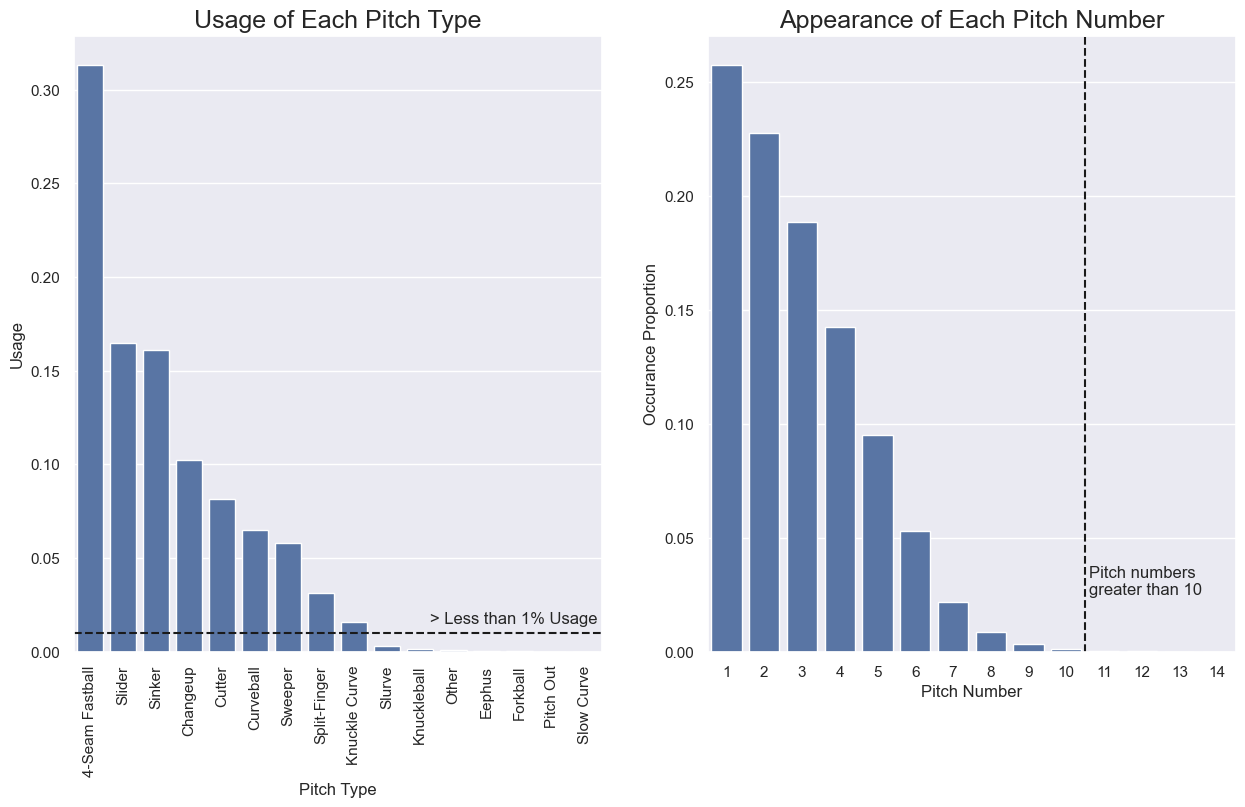

In [49]:
fig, ax = plt.subplots(1,2, figsize=(15,8))

sns.barplot(data=pitchprob_df.reset_index(names='Pitch Type'), x='Pitch Type', y='probability', ax=ax[0])
sns.barplot(data=pitchnum_prob.reset_index(names='Pitch Number'), x='Pitch Number', y = 'probability', ax=ax[1])

ax[0].set_title(label='Usage of Each Pitch Type', fontsize=18)
ax[0].set(xlabel='Pitch Type', ylabel='Usage')
ax[0].tick_params(axis='x', rotation=90)
ax[0].axhline(y=0.01, color='k', ls='--')
ax[0].annotate('> Less than 1% Usage', xy = (ax[0].patches[11].get_x() - 0.3 ,0.015))
ax[1].set_title(label='Appearance of Each Pitch Number', fontsize=18)
ax[1].set(ylabel='Occurance Proportion')
ax[1].axvline(x=9.5, color='k', ls='--')
ax[1].annotate('Pitch numbers \ngreater than 10', xy =(ax[1].patches[10].get_x(), 0.025))

plt.show()

As seen above, the pitch types used less than 1% of the time have such little usage they struggle to even be shown. This is the same for the pitch numbers greater than 10.

### 1.3 Group Assignment

The grouping of the rarely used pitches will be labeled __Rare Pitch__. This will include _'Slow Curve, Pitch Out, Forkball, Eephus, Other, Knuckleball, and Slurve'_

All pitch numbers _over 10_ will be grouped under __>10__

The data will now be regrouped in the bdf_pitch dataframe to support chi-square independance testing. The goal will be for at least 80% of the expected values to be over 5.


In [51]:
rare_pitches = ['Slow Curve', 'Pitch Out', 'Forkball', 'Eephus', 'Other', 'Knuckleball', 'Slurve']

for name in rare_pitches:  #replace the pitches above with 'Rare Pitch' in the data frame.
    bdf_pitch['pitch_name'] = bdf_pitch['pitch_name'].mask(bdf_pitch['pitch_name']==name, 'Rare Pitch')

for num in range(11,15):  #replace all pitch numbers over 10 with '>10'
    bdf_pitch['pitch_number'] = bdf_pitch['pitch_number'].mask(bdf_pitch['pitch_number']==num, '>10')

pitch_names = list(bdf_pitch['pitch_name'].unique())     #gather all unique pitch names to parse through later
pitch_nums = list(bdf_pitch['pitch_number'].unique())   

In [52]:
obs_pitch_df = pd.DataFrame(index=pd.Series(pitch_nums), columns=pitch_names)
for num in pitch_nums:
    for name in pitch_names: #repeat observed value calculations
        obs_pitch_df.loc[num, name] = len(bdf_pitch[(bdf_pitch['pitch_number']==num)&(bdf_pitch['pitch_name']==name)])

obs_pitch_df

,4-Seam Fastball,Changeup,Sinker,Knuckle Curve,Slider,Sweeper,Cutter,Curveball,Rare Pitch,Split-Finger
3,19707,7861,9459,1093,11019,4015,4967,4132,410,2562
2,22566,9686,12948,1104,12971,4545,7081,4593,560,2666
1,28746,5771,16962,1441,14041,4792,8230,6952,672,1476
4,16185,5362,6642,873,8502,3063,3401,3120,295,1919
8,1012,300,472,42,490,141,241,171,17,104
6,6108,1940,2818,256,2976,1007,1395,1060,106,622
5,10824,3449,4979,587,5512,1962,2151,2039,206,1282
7,2571,787,1212,105,1235,408,596,394,40,229
9,395,105,179,15,191,49,86,74,6,39
10,151,34,76,5,67,18,32,24,2,13


In [53]:
exp_pitch_df = pd.DataFrame(index=pd.Series(pitch_nums), columns=pitch_names)
for name in pitch_names:
    for num in pitch_nums:     #repeat expected values calculation
        exp_pitch_df.loc[num, name] = len(bdf_pitch[bdf_pitch['pitch_number']==num])*(len(bdf_pitch[bdf_pitch['pitch_name']==name])/len(bdf_pitch))

exp_pitch_df

,4-Seam Fastball,Changeup,Sinker,Knuckle Curve,Slider,Sweeper,Cutter,Curveball,Rare Pitch,Split-Finger
3,20424.473555,6657.662789,10513.28974,1041.337861,10749.683237,3772.681864,5315.8375,4255.27146,436.215751,2058.546243
2,24650.280694,8035.127861,12688.480925,1256.789827,12973.784046,4553.246705,6415.68,5135.683699,526.468439,2484.457803
1,27895.337335,9092.902633,14358.84078,1422.238416,14681.702289,5152.653408,7260.2645,5811.764621,595.774746,2811.521272
4,15457.153908,5038.490618,7956.412543,788.080023,8135.314127,2855.149439,4023.003,3220.371173,330.126208,1557.89896
8,936.284798,305.19604,481.943064,47.736301,492.779653,172.944711,243.685,195.067254,19.996705,94.366474
6,5726.681064,1866.697387,2947.750751,291.973734,3014.031538,1057.796948,1490.472,1193.107006,122.307607,577.181965
5,10330.759786,3367.465743,5317.653382,526.711803,5437.221919,1908.233766,2688.7665,2152.329026,220.639231,1041.218844
7,2372.652145,773.401471,1221.298526,120.969214,1248.759676,438.261564,617.5255,494.322604,50.673925,239.135376
9,356.665012,116.260298,183.589682,18.184497,187.717734,65.880945,92.8285,74.308228,7.617474,35.94763
10,132.144543,43.074491,68.020058,6.737364,69.549503,24.408919,34.393,27.531231,2.822277,13.318613


### This new data now has values that are above 5 for nearly every cell. A test of independance should be more accurate with these values. Since the grouped data was such a small amount of the dataset, this grouping should not sway the results in any meaningful way

_____________________________

### Goal: Determine the dependance between the pitch number and the pitch type.
### __Decide if section is worth keeping__

##### The goal is prove that a pitcher is equally as likely to use a certain pitch type regardless of which pitch number they are on during a plate appearance. In other words, do they change their pitch type as they throw more balls during the same plate appearance? <br>
##### This will prove useful later when comparing a batters behavior to a pitchers behavior, as the pitch number can be eliminated as a source of variance.

##1. Create an empty dataframe to store pitch type probabilities

   - The probability for a pitch type to be used on a certain pitch type will be stored under 'use_%'. the percentage given is the percentage that the pitch type was used out of all pitches that share the same pitch number
        - For example, if 30 out of all 300 pitches thrown on the 5th pitch (pitch number 5) was a Slider, then the Slider use_% for pitch number 5 would be 0.1.

   

The below code creates a dataframe with the index being 1 through 14 (corresponding to the pitch numbers) and the columns being the pitch names.
It then resets the index and melts the dataframe so each pitch number and pitch name combination have a row, then sorts by pitch number.

In [59]:
bdf_pitchorder = pd.DataFrame(index=pd.Series(pitch_nums), columns=pitch_names).reset_index(names='pitch_number').melt(id_vars=['pitch_number'], var_name='pitch_name', value_name='use_%')
bdf_pitchorder.head()

,pitch_number,pitch_name,use_%
0,3,4-Seam Fastball,NaN
1,2,4-Seam Fastball,NaN
2,1,4-Seam Fastball,NaN
3,4,4-Seam Fastball,NaN
4,8,4-Seam Fastball,NaN


####  2. Fill the probability dataframe made above, then check if probability of each pitch type per throw number adds to 1 within each throw number. It will be marginally off due to rounding.
   - The check is to ensure that nothing went wrong with the probability assignments.

In [61]:
for num in pitch_nums:
    num_df = bdf_pitch[bdf_pitch['pitch_number'] == num]  #Filter to only the target pitch number
    for name in pitch_names:   #For each of the pitch names, count how many times it appears in this pitch number, then divide that by the amount of pitches under the pitch number.
        bdf_pitchorder.loc[(bdf_pitchorder['pitch_number'] == num)&(bdf_pitchorder['pitch_name'] == name), 'use_%'] = round(num_df[num_df['pitch_name']==name]['pitch_name'].count()/len(num_df),4)

In [62]:
for num in pitch_nums:
    print(f'Probabilities in Pitch Number {num} add up to {bdf_pitchorder[bdf_pitchorder['pitch_number']== num].agg({'use_%':'sum'})['use_%']}')

Probabilities in Pitch Number 3 add up to 1.0
Probabilities in Pitch Number 2 add up to 1.0
Probabilities in Pitch Number 1 add up to 0.9999999999999998
Probabilities in Pitch Number 4 add up to 1.0001
Probabilities in Pitch Number 8 add up to 1.0001
Probabilities in Pitch Number 6 add up to 1.0001000000000002
Probabilities in Pitch Number 5 add up to 1.0
Probabilities in Pitch Number 7 add up to 1.0001
Probabilities in Pitch Number 9 add up to 1.0001
Probabilities in Pitch Number 10 add up to 1.0
Probabilities in Pitch Number >10 add up to 1.0000000000000002


#### 3. Calculate variance
Lets see the variance in the use percentage to get an overview on how much they change over the course of a plate appearance

In [64]:
pitch_variance = {}
#Create a dictionary of the variance in use percentages per pitch, then convert to a dataframe. This will allow one table to 
#show whether a pitch varies between pitch numbers by any significant amount
for pitch in bdf_pitchorder['pitch_name'].unique():
    usage_per_pitch = [i for i in bdf_pitchorder[bdf_pitchorder['pitch_name'] ==pitch]['use_%']]
    pitch_variance[pitch] = math.sqrt(stat.variance(usage_per_pitch))

variance_df = pd.DataFrame(data=pitch_variance, index=[0])


#### 4.Visualization of the variance
The below bar chart shows how little variance there is between pitch numbers between different pitch types. The highest being just under 0.09%

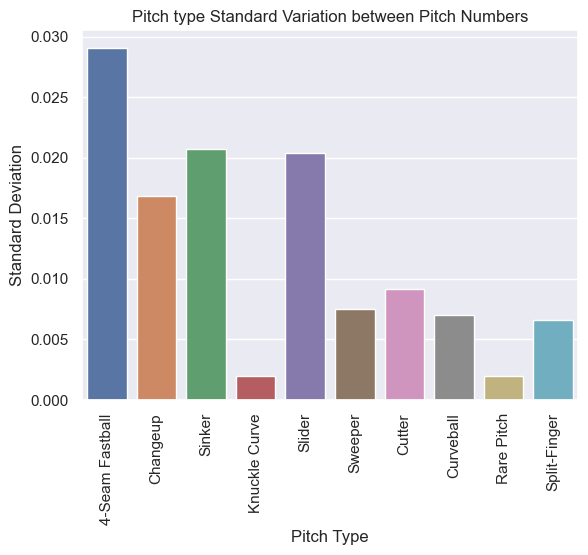

In [66]:
variance_barplot = sns.barplot(data=variance_df)
variance_barplot.set(title='Pitch type Standard Variation between Pitch Numbers', xlabel='Pitch Type', ylabel='Standard Deviation')
plt.xticks(rotation=90)
plt.show()

____________________________________________________

## 2. Independance Testing Pitch Numbers and Pitch Types

   - This will be done by conducting a chi square test on each of the pitch types, as well as the entire data set, with a confidence level of 95%.
     - I will be calculating the test statistics manually as well as with a package from scipy stats. I have not used this package extensively, so I am including a manual calculation to compare values iwith. I will run a test on one column with both the package and manual calculations before scaling it to the data set. I will not be using the package for the entire data set as its results with 2-way classification did not add up in previous tests.
     - I will be using the observed and expected values as calculated above when reclassifying my pitches and pitch numbers
    


### 2.1 Confirm sum of observed and expected values
First, it will be good to make sure that both the observed and expected sums add together to the same value before running a chi-square test. This is necessary since rounding was used.

In [70]:
for name in pitch_names:
    print(f'Observed {name} sum: {obs_pitch_df[name].sum()}\nExpected {name} sum: {exp_pitch_df[name].sum()}\nDifference: {obs_pitch_df[name].sum() - exp_pitch_df[name].sum()}\n')

Observed 4-Seam Fastball sum: 108346
Expected 4-Seam Fastball sum: 108346.0
Difference: 0.0

Observed Changeup sum: 35317
Expected Changeup sum: 35317.0
Difference: 0.0

Observed Sinker sum: 55770
Expected Sinker sum: 55770.00000000001
Difference: -7.275957614183426e-12

Observed Knuckle Curve sum: 5524
Expected Knuckle Curve sum: 5523.999999999999
Difference: 9.094947017729282e-13

Observed Slider sum: 57024
Expected Slider sum: 57023.99999999999
Difference: 7.275957614183426e-12

Observed Sweeper sum: 20013
Expected Sweeper sum: 20013.0
Difference: 0.0

Observed Cutter sum: 28199
Expected Cutter sum: 28199.000000000007
Difference: -7.275957614183426e-12

Observed Curveball sum: 22573
Expected Curveball sum: 22572.999999999996
Difference: 3.637978807091713e-12

Observed Rare Pitch sum: 2314
Expected Rare Pitch sum: 2313.9999999999995
Difference: 4.547473508864641e-13

Observed Split-Finger sum: 10920
Expected Split-Finger sum: 10919.999999999996
Difference: 3.637978807091713e-12



### 2.2 Chi-Square Test of Independance
Now I can conduct the test of independance. Both the manual and package calculations will be generated. 
- Using a 95% confidence level,
    - With a degree of freedom of 10, the cut off chi-square value is __18.307__. This will be used for the individual pitch types.
    - With a degree of freedom of 90, the cut off chi-square value is __113.1453__. This will be used for the entire data set.

In [144]:
chi_sum_entire = 0  #stores sum for the test statistic of the entire data frame

pitch_chi_values = {}

for name in pitch_names:
    pitch_name_chi = 0  #sum for test statistic of pitch type
    for num in pitch_nums:
        pitch_difference = ( ((obs_pitch_df.loc[num, name]) - (exp_pitch_df.loc[num, name]))**2 ) / (exp_pitch_df.loc[num, name]) #chi-square summation
        pitch_name_chi += pitch_difference #add to pitch type chi-square
        chi_sum_entire += pitch_difference #add to data set chi-square
    pitch_chi_values[name] = round(pitch_name_chi,3)
    package_pitch_chi = scipy.chisquare(np.array(obs_pitch_df[name]), f_exp=np.array(exp_pitch_df[name]))
    print(f'{name}: \n    Manual:  {round(pitch_name_chi,3)}, D.F. = 10\n    Package: {round(package_pitch_chi[0],3)}, D.F. = 10')

pitch_dof = (len(obs_pitch_df.columns)-1) * (len(obs_pitch_df.index)-1) #get degrees of freedom for dataset using (row-1)(column-1)
print(f'Entire Dataset:\n    Manual:  {round(chi_sum_entire,3)}, D.F. = 90\n    Package: {round(scipy.chi2_contingency(obs_pitch_df)[0],3)}, D.F. = 90')

4-Seam Fastball: 
    Manual:  344.888, D.F. = 10
    Package: 344.888, D.F. = 10
Changeup: 
    Manual:  1799.301, D.F. = 10
    Package: 1799.301, D.F. = 10
Sinker: 
    Manual:  831.605, D.F. = 10
    Package: 831.605, D.F. = 10
Knuckle Curve: 
    Manual:  45.69, D.F. = 10
    Package: 45.69, D.F. = 10
Slider: 
    Manual:  58.474, D.F. = 10
    Package: 58.474, D.F. = 10
Sweeper: 
    Manual:  74.041, D.F. = 10
    Package: 74.041, D.F. = 10
Cutter: 
    Manual:  433.065, D.F. = 10
    Package: 433.065, D.F. = 10
Curveball: 
    Manual:  332.396, D.F. = 10
    Package: 332.396, D.F. = 10
Rare Pitch: 
    Manual:  24.985, D.F. = 10
    Package: 24.985, D.F. = 10
Split-Finger: 
    Manual:  915.725, D.F. = 10
    Package: 915.725, D.F. = 10
Entire Dataset:
    Manual:  4860.17, D.F. = 90
    Package: 4860.17, D.F. = 90


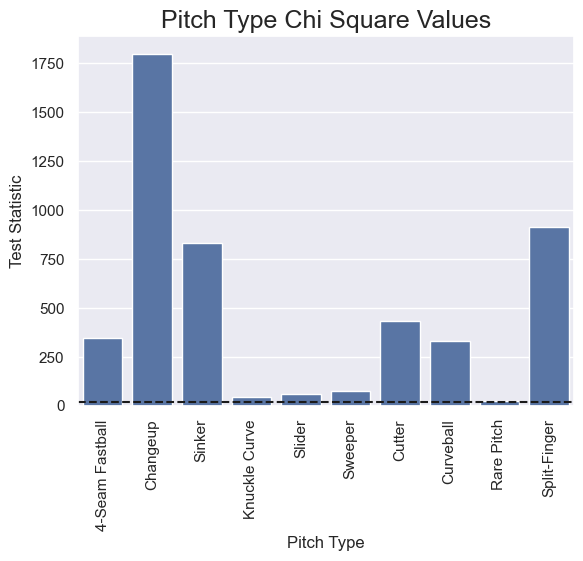

In [141]:
pitch_chi_plot = sns.barplot(data=pitch_chi_values)
pitch_chi_plot.set_title(label='Pitch Type Chi Square Values', fontsize=18)
pitch_chi_plot.set(xlabel='Pitch Type', ylabel='Test Statistic')
pitch_chi_plot.tick_params(axis='x', rotation=90)
pitch_chi_plot.axhline(y=18.307, color='k', ls='--')

### 2.3 Conclusion

Every single pitch type failed the independance with a 95% confidence level. The graph about shows that some pitch types had some extremely high chi-square values as compared to others though. While post hoc testing will need to be done, this can give some insight to where the stronger dependancies lie. 

According to these tests, Pitch Type is dependent on Pitch Number. If the dependancies can be found, we can see how they may change between different types of batters.

____________________________________________________

## Goal: Filter to only the frequent batters

### 1. player_name is the name of the _batter_. We create a new dataframe with just the batter and game information to make parsing faster

In [215]:
bdf_batters = bdf[['player_name','batter','game_pk','at_bat_number']]

### 2. Create a dataframe that has each player with their corresponding ID and an empty column for average plate appearance per game. then create a list of all unique player ids to iterate through.

In [217]:
bdf_players = bdf[['player_name','batter']].drop_duplicates(subset='batter') #create dataframe with player name and id, with each player appearing once
bdf_players['avg_plate_app'] = pd.Series()   #add empty column to contain a players average plate appearances per game
player_ids = list(bdf_players['batter'].unique()) #list of all unique player ids
bdf_players.head()

,player_name,batter,avg_plate_app
0,"Rocchio, Brayan",677587,NaN
3,"Ohtani, Shohei",660271,NaN
4,"Hedges, Austin",595978,NaN
5,"Casas, Triston",671213,NaN
6,"Rizzo, Anthony",519203,NaN


### 3. Create dataframe with only unique plate appearances. this removes entries for subsequent pitches in the same plate appearance

In [219]:
bdf_plateapp = bdf_batters.drop_duplicates(subset=['game_pk','at_bat_number'], keep='first') 

### 4. Update the avg_plate_app with the average plate appearances per player than check if any player was missed

In [221]:
for id in player_ids: #find count of plate appearances and total games for a player, then divide appearance by total games for their average.
    plateapp = len(bdf_plateapp[bdf_plateapp['batter']==id])
    tot_games = len(bdf_plateapp[bdf_plateapp['batter']==id]['game_pk'].unique())
    bdf_players.loc[bdf_players.index[bdf_players['batter']==id], 'avg_plate_app'] = plateapp/tot_games #update dataframe with calculated average

bdf_players.isna().sum() #confirm all players have an corresponding average plate appearance

player_name      0
batter           0
avg_plate_app    0
dtype: int64

In [222]:
bdf_players.head()

,player_name,batter,avg_plate_app
0,"Rocchio, Brayan",677587,3.523077
3,"Ohtani, Shohei",660271,4.52
4,"Hedges, Austin",595978,3.0
5,"Casas, Triston",671213,3.941176
6,"Rizzo, Anthony",519203,4.138462


In [223]:
print('There are ' + str(len(bdf_players.query('avg_plate_app >= 3.1'))) + ' with over 3.1 average plate appearances per game')
print('Total Players Found: ' + str(len(bdf_players)))

There are 406 with over 3.1 average plate appearances per game
Total Players Found: 559


## Out of all 559 players, 406 were found to meet our requirements of being a frequent batter. This list can be used later in the project to gauge behaviors and swing characteristics of the usual batters, which can then be compared to any potential changes in how a pitcher throws.